# Automated Patent Landscaping

This notebook walks through the process of creating a patent landscape as described in the paper [Automated Patent Landscaping](AutomatedPatentLandscaping.pdf) (Abood, Feltenberger 2016). The basic outline is:
* load pre-trained word embeddings
* load a seed set of patents and generate the positive and negative training data
* train a deep neural network on the data
* show how to do inference using the model

If you haven't already, please make sure you've setup an environment following the instructions in the [README](README.md) so you have all the necessary dependencies.

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Your Cloud Project ID
You'll need a Google Cloud project with BigQuery enabled (it's enabled by default) for this notebook and associated code to work. Put your project ID below. Go to [cloud.google.com](http://cloud.google.com) to create one if you don't already have an account. You can create the Cloud account for free and won't be auto-billed. Then copy your Project ID and paste it below into `bq_project`.
![Project ID](figs/project-id.png)


In [1]:
# bq_project = 'patent-landscape-165715'
bq_project = ''

## Basic Configuration

In [2]:
import tensorflow as tf
import pandas as pd
import os

seed_name = 'hair_dryer'
seed_file = 'seeds/hair_dryer_large.seed.csv'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000
if bq_project == '':
    raise Exception('You must enter a bq_project above for this code to run.')

## Download Embedding Model if Necessary
We provide a pre-trained word2vec word embedding model that we trained on 5.9 million patent abstracts. See also `word2vec.py` in this repo if you'd like to train your own (though gensim is likely an easier path). The code below will download the model from Google Cloud Storage (GCS) and store it on the local filesystem, or simply load it from local disk if it's already present.

In [3]:
from word2vec import W2VModelDownload

model_name = '5.9m'
model_download = W2VModelDownload(bq_project)
model_download.download_w2v_model('patent_landscapes', model_name)
print('Done downloading model {}!'.format(model_name))

Model 5.9m already exists. Using local copy.
Done downloading model 5.9m!


## Load Word2Vec Embeddings

This loads Word2Vec embeddings from a model trained on 5.9 million patent abstracts. Just as a demonstration, this also finds the k most similar words to a given word ranked by closeness in the embedding space. Finally, we use tSNE to visualize the word closeness in 2-dimensional space.

Note that the actual model files are fairly large (e.g., the 5.9m dataset is 760mb per checkpoint), so they are not stored in the Github repository. They're stored in the [patent_landscapes](https://console.cloud.google.com/storage/browser/patent_landscapes) Google Cloud Storage bucket under the models/ folder. If you'd like to use them, download the `models` folder and put it into the root repository folder (e.g., if you checked out this repository into the `patent-models` folder, then the `5.9m` model should be in `patent-models/models/5.9m`, for example.

In [3]:
from word2vec import Word2Vec

word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [4]:
w2v_runtime.find_similar('hair', 10)

[{'distance': 0.27630654787113296, 'index': 12541, 'word': 'styling'},
 {'distance': 0.32142541152072901, 'index': 10423, 'word': 'scalp'},
 {'distance': 0.36028431858499232, 'index': 12575, 'word': 'hairs'},
 {'distance': 0.38895446681450585, 'index': 3634, 'word': 'cosmetic'},
 {'distance': 0.39621903141812476, 'index': 9330, 'word': 'keratin'},
 {'distance': 0.40511075285155751, 'index': 13313, 'word': 'keratinous'},
 {'distance': 0.4064818428717476, 'index': 1239, 'word': 'skin'},
 {'distance': 0.42916960591675168, 'index': 13269, 'word': 'shampoo'},
 {'distance': 0.43838439284560793, 'index': 12240, 'word': 'cosmetically'},
 {'distance': 0.44125860932789462, 'index': 16618, 'word': 'curler'}]

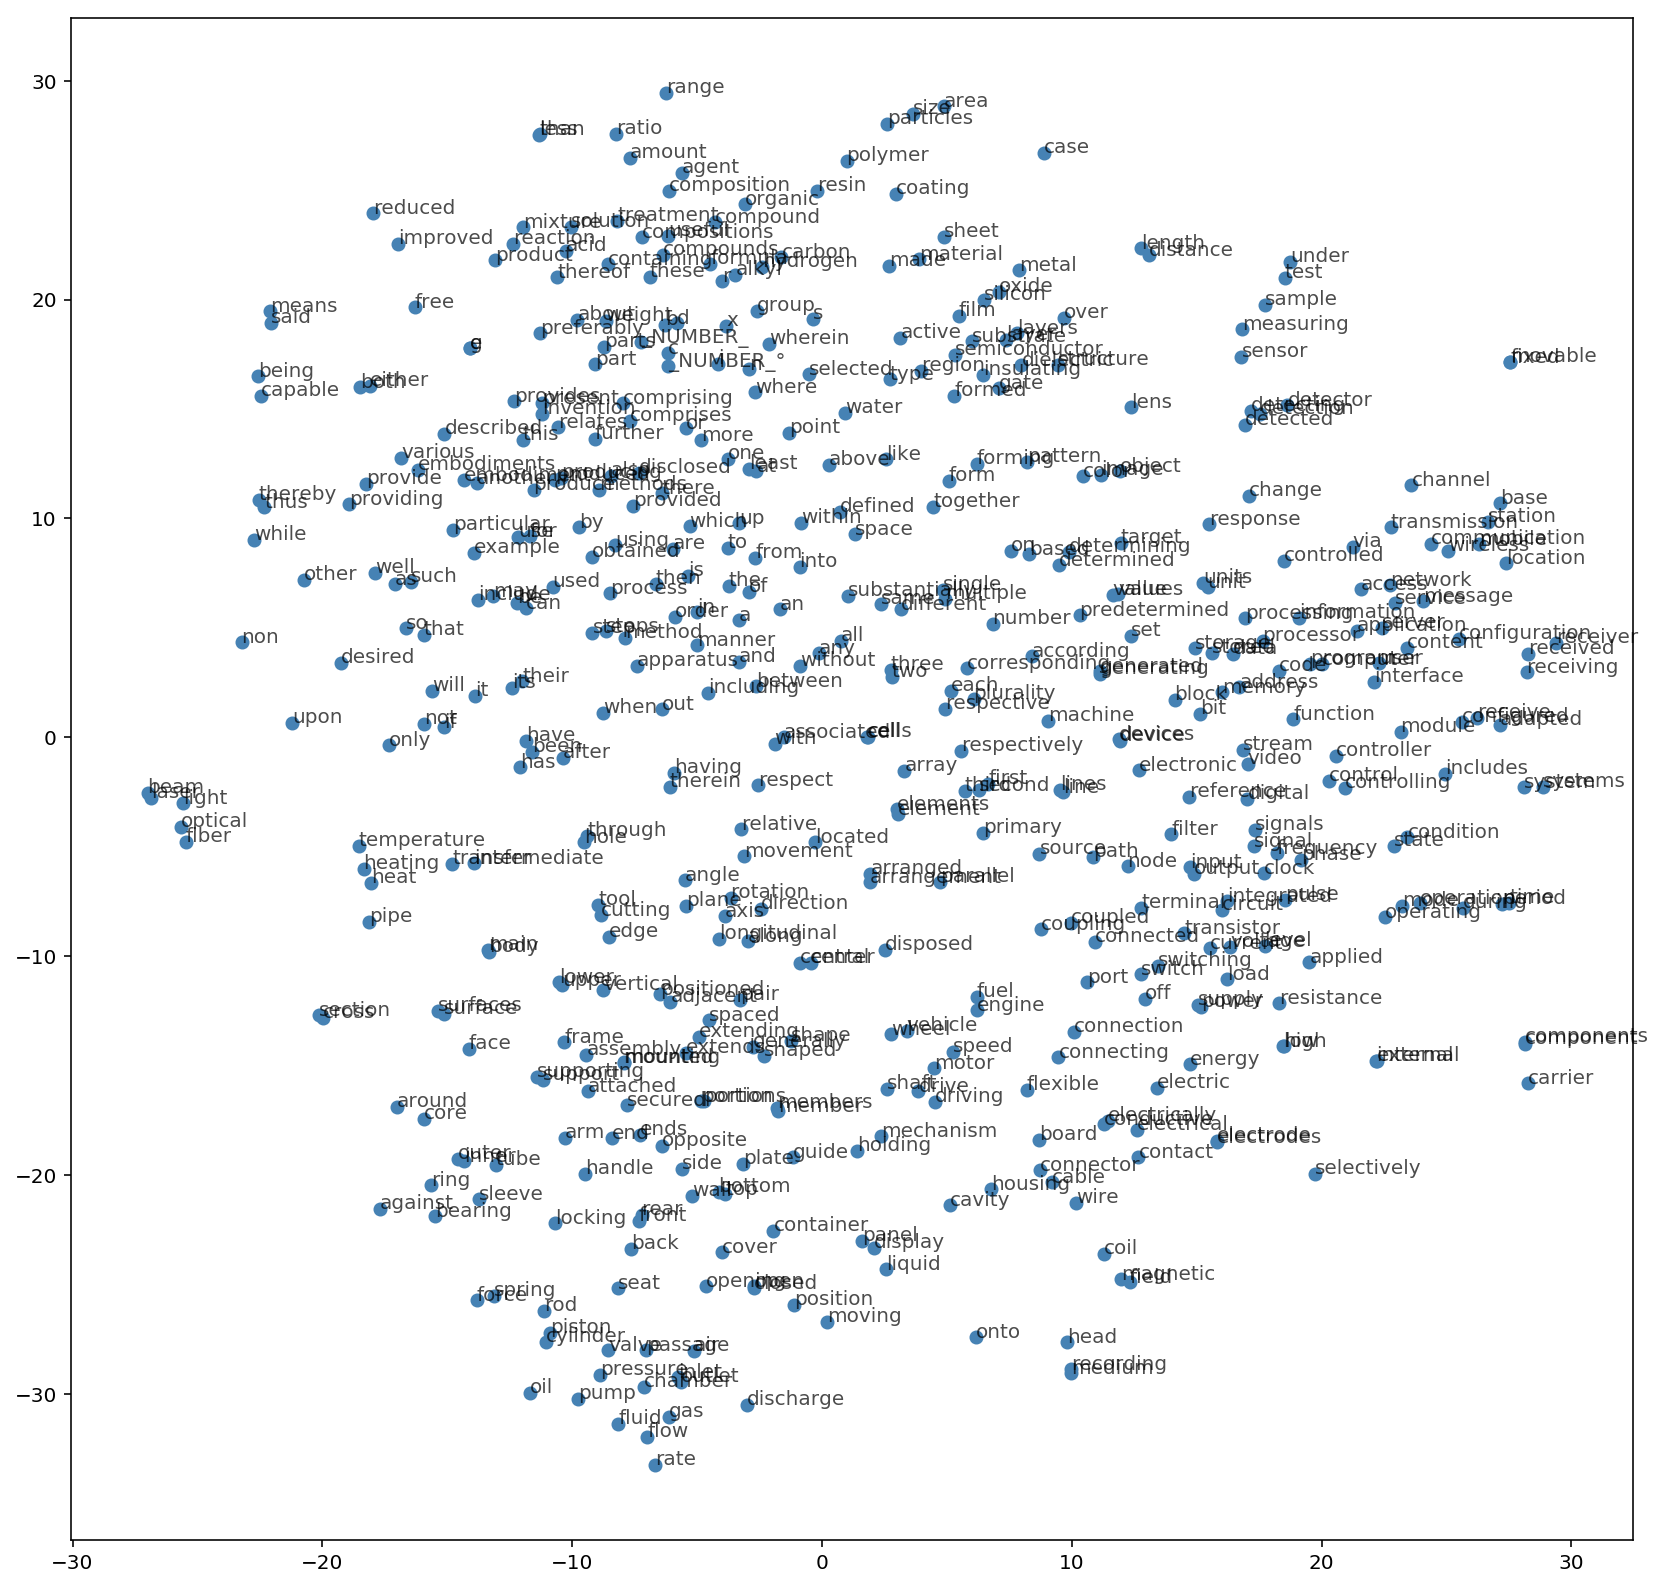

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

w2v_runtime.visualize_embeddings(500)

## Patent Landscape Expansion

This section of the notebook creates an instance of the `PatentLandscapeExpander`, which accesses a BigQuery table of patent data to do the expansion of a provided seed set and produces each expansion level as well as the final training dataset as a Pandas dataframe.

In [4]:
import expansion

expander = expansion.PatentLandscapeExpander(
    seed_file,
    seed_name,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


This does the actual expansion and displays the head of the final training data dataframe.

In [5]:
training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.load_from_disk_or_do_expansion()

training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel', 'refs', 'cpcs']]
training_data_full_df.head()


Loading landscape data from filesystem at data/hair_dryer/landscape_data.pkl


,pub_num,publication_number,family_id,priority_date,title_text,abstract_text,claims_text,description_text,refs,cpcs,ExpansionLevel
0,2012223161,US-2012223161-A1,46752712,20110301,Ready-to-use hose end sprayer,A ready-to-use sprayer comprises a container d...,unused,unused,"US-3122325-A,US-3122325-A,US-3122325-A,US-3122...","B05B1/3026,B05B7/244,A01M7/0046,B05B7/2443,A01...",AntiSeed
1,2007061068,US-2007061068-A1,37177932,20050909,Information indication device for vehicle,There are provided a first monitor with a firs...,unused,unused,"US-6285952-B1,US-6285952-B1,US-6285952-B1,US-6...","G01C21/3626,B60K35/00,G08G1/0969,G01C21/265,G0...",AntiSeed
2,8082090,US-8082090-B2,37454390,20050909,Method and device for operation of the glow pl...,A method and device for operation of glow plug...,unused,unused,"US-4162669-A,US-4162669-A,US-4162669-A,DE-3123...","F02P19/023,F02P19/025,F02P19/027,F02P19/023,F0...",AntiSeed
3,4466167,US-4466167-A,26746235,19790813,Method of removing stuck gaskets and pneumatic...,A pneumatic impact tool has a tubular housing ...,unused,unused,"US-11887-A,US-11887-A,US-11887-A,US-11887-A,US...","B25B27/0028,Y10T29/5393,B25D9/04,B25D9/16,B25D...",AntiSeed
4,6552808,US-6552808-B2,23638822,19991006,"Methods and apparatus for splitting, imaging, ...","Apparatus for splitting, imaging, and measurin...",unused,unused,"US-4076423-A,US-4076423-A,US-4076423-A,US-4076...","G01B2290/70,G01B9/02087,G01B9/02081,G01B2290/4...",AntiSeed


### Show some stats about the landscape training data

In [6]:
print('Seed/Positive examples:')
print(training_df[training_df.ExpansionLevel == 'Seed'].count())

print('\n\nAnti-Seed/Negative examples:')
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

Seed/Positive examples:
publication_number    265
title_text            265
abstract_text         265
claims_text           265
description_text      265
ExpansionLevel        265
refs                  265
cpcs                  265
dtype: int64


Anti-Seed/Negative examples:
publication_number    10016
title_text            10016
abstract_text         10016
claims_text           10016
description_text      10016
ExpansionLevel        10016
refs                  10016
cpcs                  10016
dtype: int64


## Preparing / Transforming Training Data

The following takes the input landscape training dataframe and transforms it into a format readable by TensorFlow and Keras.

In [14]:
import train_data
import tokenizer

# TODO: persist this tokenization data too
td = train_data.LandscapeTrainingDataUtil(training_df, w2v_runtime)
td.prepare_training_data(
    training_df.ExpansionLevel,
    training_df.abstract_text,
    training_df.refs,
    training_df.cpcs,
    0.8,
    50000,
    500)

No Keras tokenizer supplied so using vocab size (50000) and series to build new one
No Keras tokenizer supplied so using vocab size (500) and series to build new one
Randomizing training data
Creating NumPy arrays for train/test set out of randomized training data.
Train (embed) data shapes: train: (8224,), train labels shape: (8224,)
Test (embed) data shape: (2057,), test labels shape: (2057,)
doc lengths for embedding layer: median: 104, mean: 104.90588521400778, max: 976
Using sequence length of 976 to pad LSTM sequences.
Training data ready.


### Show some sample training data

In [8]:
pos_idx = -1
neg_idx = -1
for idx in range(0, len(td.prepped_labels)):
    if td.prepped_labels[idx] == 0 and pos_idx < 0:
        pos_idx = idx
    if td.prepped_labels[idx] == 1 and neg_idx < 0:
        neg_idx = idx

    if pos_idx > -1 and neg_idx > -1:
        break

print('Showing positive example (instance #{}).'.format(pos_idx))
td.show_instance_details(pos_idx)
print('\n------------------------------------\n')
print('Showing negative example (instance #{}).'.format(neg_idx))
td.show_instance_details(neg_idx)


Showing positive example (instance #45).

Original: A hand-held hair-dryer comprises a substantially spherical casing containing an electric heating element associated with an impeller driven by an electric motor. The casing comprises first and second hemispherical caps joined together to form a spherical body with at least one our admission opening between the joined edges of the caps. The impeller is arranged for air to be drawn into the casing through the air admission opening, to then pass into contact with the heating element and finally to pass through the impeller for discharge through a radially directed air-ejection nozzle carried by one of the caps. The dimesions of the spherical casing are such that the hair-dryer can be grasped in the palm of the hand.
Tokenized: a hand held hair dryer comprises a substantially spherical casing containing an electric heating element associated with an impeller driven by an electric motor casing comprises first and second hemispherical caps 

# Train Model

The following cells specify hyperparameters, the neural network architecture (using Keras) and actually trains and tests the model.

The model is generally composed of:
* sequential word embeddings from the patent Abstract of each training instance
* references one-hot encoded into a fully-connected layer
* CPC codes one-hot encoded into a fully-connected layer
* the above three layers concatenated into a final fully-connected layer
* a final, single sigmoid layer with the classification result


### Model Hyperparameters

In [9]:
batch_size = 32
dropout_pct = 0.4

# Convolution (not currently used)
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_size = 128

### Build the Deep Neural Network

In [15]:
import model
import importlib
importlib.reload(model)

model = model.LandscapeModel(td, 'data', seed_name)
model.wire_model_functional(lstm_size, dropout_pct, sequence_len=td.sequence_len)

Building Functional model.
Done building graph.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
refs_input (InputLayer)          (None, 50000)         0                                            
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 256)           12800256    refs_input[0][0]                 
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 256)           0           dense_8[0][0]                    
____________________________________________________________________________________________________
embed_input (InputLayer)         (None, 976)           0                                            
___________________________________________

### Train / Fit the Network

In [16]:
model.train_or_load_model(batch_size)

Model has not been trained yet.
Training model.
Train on 8224 samples, validate on 2057 samples
Epoch 1/5
8224/8224 [==============================] - 511s - loss: 0.2269 - acc: 0.9232 - precision: 0.9803 - recall: 0.9400 - fmeasure: 0.9565 - val_loss: 0.0746 - val_acc: 0.9810 - val_precision: 0.9815 - val_recall: 0.9995 - val_fmeasure: 0.9902
Epoch 2/5
8224/8224 [==============================] - 482s - loss: 0.0824 - acc: 0.9782 - precision: 0.9837 - recall: 0.9942 - fmeasure: 0.9887 - val_loss: 0.0528 - val_acc: 0.9854 - val_precision: 0.9887 - val_recall: 0.9965 - val_fmeasure: 0.9924
Epoch 3/5
8224/8224 [==============================] - 499s - loss: 0.0652 - acc: 0.9830 - precision: 0.9866 - recall: 0.9962 - fmeasure: 0.9912 - val_loss: 0.0565 - val_acc: 0.9849 - val_precision: 0.9887 - val_recall: 0.9960 - val_fmeasure: 0.9922
Epoch 4/5
8224/8224 [==============================] - 503s - loss: 0.0539 - acc: 0.9850 - precision: 0.9888 - recall: 0.9959 - fmeasure: 0.9922 - val_los

### Evaluate the Model on the Test Set

In [17]:
score, acc, p, r, f1 = model.evaluate_model(batch_size)

2057/2057 [==============================] - 53s    

Test score: 0.0242
Test accuracy: 0.9951
Test p/r (f1): 1.00/1.00 (1.00)


------

# Inference

*NOTE*: the below inference code assumes you've already trained a model _in the currently active kernel_ such that the following variables are already set:
* `model` is the Keras-trained DNN
* `l1_patents_df` is the dataframe returned by the PatentLandscapeExpander

Future iterations will save model checkpoints and allow saving off models and then loading them later just for inference.

### Load Inference Data

This randomly selects a subset of the L1 patents (that we got from reference and CPC expansions) and loads the details (text, CPCs, refs, etc.) from BigQuery.

In [20]:
subset_l1_pub_nums, l1_texts, padded_abstract_embeddings, refs_one_hot, cpc_one_hot = \
    expander.sample_for_inference(td, 1.0)

Loading inference data from BigQuery.
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (2009, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Saving inference data to data/hair_dryer/landscape_inference_data.pkl.


#### Classification of L1

We use a very rough heuristic to determine what the "ground truth" is for our L1 expansion -- whether something contains both the string "hair" and "dry"; if it does, we consider it a positive example; if not, we consider it a negative example. We can explore our positives, false positives, negatives, and false negatives in the confusion matrix and Pandas DataFrame below.

In [21]:
predictions = model.batch_predict(padded_abstract_embeddings, refs_one_hot, cpc_one_hot)

In [22]:
l1_texts['score'] = pd.DataFrame(predictions, columns=['score'])['score']
l1_texts['label'] = 'Seed'
l1_texts[['publication_number', 'score', 'label', 'abstract_text', 'refs', 'cpcs']]
l1_texts['has_hair'] = l1_texts.abstract_text.str.lower().str.contains('hair')
l1_texts['has_dry'] = l1_texts.abstract_text.str.lower().str.contains('dry')
l1_texts.loc[(l1_texts.has_hair == False) & (l1_texts.has_dry == False), 'label'] = 'AntiSeed'
# Shows the CPC codes from an example item from our inference dataframe.
l1_texts['cpcs'].iloc[0]


'A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12,A45D20/12'

In [23]:
classify_report, confusion_matrix = model.reports(l1_texts)

print(classify_report)

print('Confusion matrix:\n{}'.format(confusion_matrix))
model.show_confusion_matrix(confusion_matrix)

             precision    recall  f1-score   support

       seed       0.65      0.99      0.79       712
   antiseed       0.99      0.57      0.72       860

avg / total       0.84      0.76      0.75      1572

Confusion matrix:
[[705   7]
 [373 487]]


#### Classified as 'hair dryer', but doesn't have the words 'hair' or 'dry' in the abstract
These are good candidates for false positives. You can also explore the negatives to see whether they seem accurate or not.

In [26]:
predicted_seed_class = l1_texts.score <= 0.5
predicted_nonseed_class = l1_texts.score > 0.5

l1_texts[
    (predicted_seed_class) & (l1_texts.has_hair == False) & (l1_texts.has_dry == False)
  ].abstract_text.iloc[1]


'A heat gun quickly and efficiently dries joint compound. The heat gun includes an outer shroud defining an airflow chamber and a fan which drives airflow therethrough. A motor provides drive to the fan while a plurality of heating coils disposed within the airflow chamber heat the airflow between 1200 and 1700 ° Fahrenheit. A fan-shaped attachment is attached about an endcap of the heat gun. The fan-shaped attachment extends into a pair of sidewall surfaces terminating in an elongated port. The elongated port is preferably between 1/2 and 3 inches in diameter and between 8 and 12 inches in length. The endcap of the heat gun is between 1 and 3 inches in diameter. A plurality of ribs connect the pair of sidewall surfaces and extend longitudinally from the endcap of the heat gun to the elongated port of the fan-shaped attachment to define a plurality of longitudinal air passages which evenly distribute airflow along the fan-shaped attachment. Each of a portion of the ribs includes an air

#### Ad-hoc classification
If you want to experiment with ad-hoc classification of data, edit the fields below for abstract text, references, and CPC codes to see how it influences the model's output. Somewhat counter-intuitively, a score closer to 0 means more likely to be an instance of the seed class (e.g., more likely to be about 'hair dryers'); conversely, the closer to 1, the more likely the model thinks the instance is part of the **anti** seed class.

In [25]:
# A conditioner infuser cartridge for use with a dryer attachment having an attachment end for engagement with a hair dryer barrel, an opposite air outlet end and a perforated portion between the ends having at least one air intake, the cartridge configured for engagement near the attachment end and including a conditioner element constructed and arranged for retaining a supply of vaporizable conditioner and a support frame receiving the conditioner element and securing same in the attachment.
# An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or catalytic wrappings may be used on the refractory surfaces which will be radiantly heated by the manually mountable-demountable form of bulb or resistance heating element

#A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08,A45D20/10,A45D20/08

text = 'An electric lamp bulb or electric resistance coil is provided to radiate heat to one or more adjacent surfaces which have an active oxidation catalyst such that fumes and odors in the confines of a room that are drawn over the catalytic surface will be converted to less objectionable products. A catalytic device with an incandescent light bulb type of heating element is of particular advantage in that it can readily be screwed into a lamp base or mounted in other forms of current supplying receptacles and, in addition to a light source, will provide a heat emitting surface for heating the catalyst surface and inducing natural air convection current flow past the catalytic surface. Also, a fume control device which utilizes a resistance heating coil can readily provide both radiant heat and convection heat so that there will be the dual function of fume oxidation from air flow past a heated catalyst surface and radiant heat into a room area. Various types of catalyst coatings and/or catalytic wrappings may be used on the refractory surfaces which will be radiantly heated by the manually mountable-demountable form of bulb or resistance heating element'
refs = ''
cpcs = ''

model.predict(td, text, refs, cpcs)


array([[ 0.99693078]], dtype=float32)